<a href="https://colab.research.google.com/github/thunderhoser/ams2026_ml_short_course/blob/master/ams2026_uq_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine learning for uncertainty quantification in atmospheric science

This notebook was used for the machine-learning short course at the 2026 Annual Meeting of the American Meteorological Society.

If you use code from this notebook, please cite it as follows.

Lagerquist, Ryan, and David John Gagne II, 2026: "Machine learning for uncertainty quantification in atmospheric science". *Intermediate Machine Learning in Python for Environmental Science Problems*, American Meteorological Society, Houston, Texas, https://www.ametsoc.org/ams/education-careers/careers/professional-development/short-courses/intermediate-machine-learning-in-python-for-environmental-science-problems-2026.

# <font color='red'>Note: Make sure to use a GPU (graphical processing unit) to run this notebook!</font>

The CNNs in this notebook run $\sim$100 times faster with a GPU.  To request a GPU, do the following:

 1. Click on "Runtime" in the menu at the top (next to "File," "Edit," "View," etc.).
 2. Click on "Change runtime type".
 3. Click on "GPU" under the "Hardware accelerator" dropdown menu.

# References

This notebook refers to a few publications, listed below.  Schwartz *et al.* (2015) documents the dataset used.

Ebert, E., 2001: "Ability of a poor man’s ensemble to predict the probability and distribution of precipitation." *Monthly Weather Review*, **129 (10)**, 2461-2480, https://journals.ametsoc.org/doi/full/10.1175/1520-0493%282001%29129%3C2461%3AAOAPMS%3E2.0.CO%3B2.

Erhan, D., Y. Bengio, A. Courville, and P. Vincent, 2009: "Visualizing higher-layer features of a deep network." Technical report, University of Montr&eacute;al, https://www.researchgate.net/profile/Aaron_Courville/publication/265022827_Visualizing_Higher-Layer_Features_of_a_Deep_Network/links/53ff82b00cf24c81027da530.pdf.

Schwartz, C., G. Romine, M. Weisman, R. Sobash, K. Fossell, K. Manning, and S. Trier, 2015: "A real-time convection-allowing ensemble prediction system initialized by mesoscale ensemble Kalman filter analyses." *Weather and Forecasting*, **30 (5)**, 1158-1181, https://doi.org/10.1175/WAF-D-15-0013.1.

Selvaraju, R., M. Cogswell, A. Das, R. Vedantam, D. Parikh, and D. Batra, 2017: "Grad-CAM: Visual explanations from deep networks via gradient-based localization." *International Conference on Computer Vision*, Venice, Italy, IEEE, http://openaccess.thecvf.com/content_ICCV_2017/papers/Selvaraju_Grad-CAM_Visual_Explanations_ICCV_2017_paper.pdf.

Wagstaff, K., and J. Lee: "Interpretable discovery in large image data sets." *arXiv e-prints*, **1806**, https://arxiv.org/abs/1806.08340.

Zhou, B., A. Khosla, A. Lapedriza, A. Oliva, and A. Torralba, 2016: "Learning deep features for discriminative localization." *Conference on Computer Vision and Pattern Recognition*, Las Vegas, Nevada, IEEE, https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf.

# <font color='red'>Clone the Git repository (required)</font>

- **Please note**: when a section title is in <font color='red'>red</font>, that means the code cell below is required.
- In other words, if you don't run the code cell below, subsequent code cells might not work.

In [1]:
import os
import shutil

if os.path.isdir('course_repository'):
    shutil.rmtree('course_repository')

!git clone https://github.com/thunderhoser/ams2026_ml_short_course course_repository
!cd course_repository; python setup.py install

!pip uninstall -y netCDF4
!pip install netCDF4

!pip uninstall -y cftime
!pip install cftime

Cloning into 'course_repository'...
remote: Enumerating objects: 185, done.
remote: Counting objects: 100% (185/185), done.
remote: Compressing objects: 100% (137/137), done.
remote: Total 185 (delta 106), reused 125 (delta 46), pack-reused 0 (from 0)
Receiving objects: 100% (185/185), 81.20 KiB | 4.27 MiB/s, done.
Resolving deltas: 100% (106/106), done.
running install
/usr/local/lib/python3.12/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.12/dist-packages/setupt

# <font color='red'>Import packages (required)</font>

The next two cells import all packages used in the notebook.

In [2]:
import sys

sys.path.append('/content/data/')
sys.path.append('/content/course_repository/')
sys.path.append('/content/course_repository/ams2026_ml_short_course/')
sys.path.append('/content/course_repository/ams2026_ml_short_course/utils/')

In [3]:
%matplotlib inline
import os
os.environ['KERAS_BACKEND'] = 'jax'
os.environ['JAX_TRACEBACK_FILTERING'] = 'off'
import copy
import random
import warnings
import numpy
import keras
from matplotlib import pyplot
from ams2026_ml_short_course.utils import utils, image_utils, \
    image_normalization
from ams2026_ml_short_course.utils import spread_skill_utils
from ams2026_ml_short_course.utils import pit_utils
from ams2026_ml_short_course.utils import discard_test_utils
from ams2026_ml_short_course.machine_learning import crps_lf
from ams2026_ml_short_course.machine_learning import neural_net
from ams2026_ml_short_course.machine_learning import custom_losses
from ams2026_ml_short_course.machine_learning import custom_metrics
from ams2026_ml_short_course.plotting import image_plotting

warnings.filterwarnings('ignore')

SEPARATOR_STRING = '\n\n' + '*' * 50 + '\n\n'
MINOR_SEPARATOR_STRING = '\n\n' + '-' * 50 + '\n\n'

DATA_DIRECTORY_NAME = '/content/data/track_data_ncar_ams_3km_nc_small'

# <font color='red'>Prevent auto-scrolling (required)</font>

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# <font color='red'>Download input data (required)</font>

The next cell downloads all input data used in this notebook.

In [5]:
!python /content/course_repository/download_image_data.py

Unzipping file: "data/track_data_ncar_ams_3km_nc_small.tar.gz"...
/content/course_repository/download_image_data.py:65: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar_file_handle.extractall(LOCAL_DIRECTORY_NAME)


# <font color='red'>Read input data (required)</font>

The next cell reads all input data for this notebook into memory.

In [6]:
# training_file_names = image_utils.find_many_files(
#     first_date_string='20100101', last_date_string='20141224',
#     directory_name=DATA_DIRECTORY_NAME
# )

training_file_names = image_utils.find_many_files(
    first_date_string='20100101', last_date_string='20111231',
    directory_name=DATA_DIRECTORY_NAME
)

validation_file_names = image_utils.find_many_files(
    first_date_string='20150101', last_date_string='20151231',
    directory_name=DATA_DIRECTORY_NAME
)

# testing_file_names = image_utils.find_many_files(
#     first_date_string='20160101', last_date_string='20171231',
#     directory_name=DATA_DIRECTORY_NAME
# )

training_image_dict = image_utils.read_many_files(training_file_names)
print('\n')

validation_image_dict = image_utils.read_many_files(validation_file_names)
print('\n')

# testing_image_dict = image_utils.read_many_files(testing_file_names)

Reading data from: "/content/data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20101024-0000_d01_model_patches.nc"...
Reading data from: "/content/data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20101122-0000_d01_model_patches.nc"...
Reading data from: "/content/data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110201-0000_d01_model_patches.nc"...
Reading data from: "/content/data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110308-0000_d01_model_patches.nc"...
Reading data from: "/content/data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110326-0000_d01_model_patches.nc"...
Reading data from: "/content/data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110404-0000_d01_model_patches.nc"...
Reading data from: "/content/data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110414-0000_d01_model_patches.nc"...
Reading data from: "/content/data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110420-0000_d01_model_patches.nc"...
Reading data from: "/content/data/track_data_ncar_ams_3km_nc_small/NCARS

# Data exploration

## Plot random example with wind barbs

 - The next cell plots a random example with wind barbs.
 - One example = one storm object = one storm cell at one time.

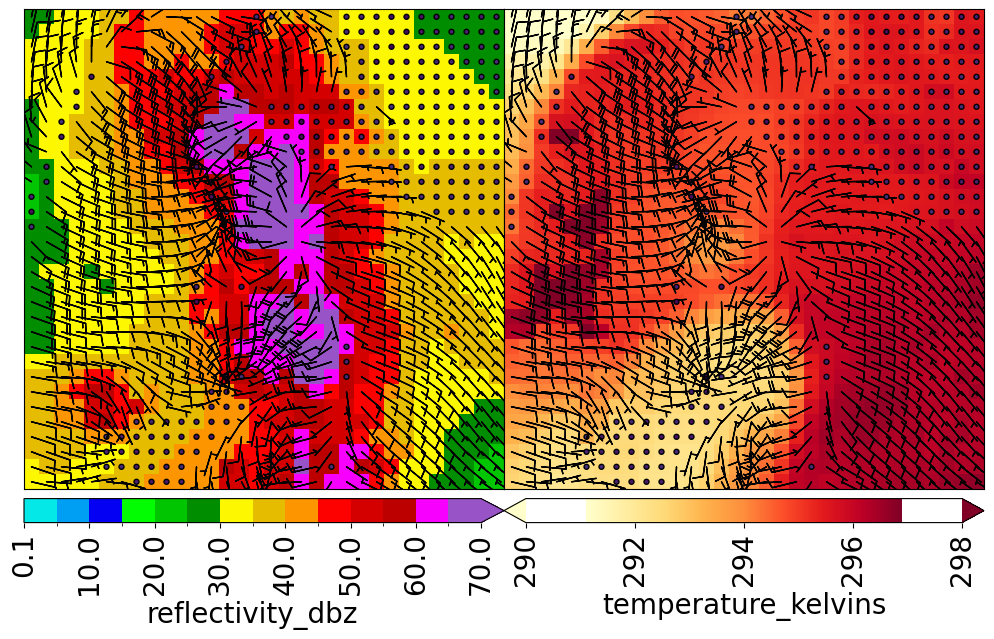

In [7]:
predictor_matrix = (
    validation_image_dict[image_utils.PREDICTOR_MATRIX_KEY]
)
predictor_names = validation_image_dict[image_utils.PREDICTOR_NAMES_KEY]

num_examples = predictor_matrix.shape[0]
random_index = random.randint(0, num_examples - 1)
predictor_matrix = predictor_matrix[random_index, ...]

temperature_matrix_kelvins = predictor_matrix[
    ..., predictor_names.index(image_utils.TEMPERATURE_NAME)
]
min_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 1)
max_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 99)

image_plotting.plot_many_predictors_with_barbs(
    predictor_matrix=predictor_matrix, predictor_names=predictor_names,
    min_colour_temp_kelvins=min_temp_kelvins,
    max_colour_temp_kelvins=max_temp_kelvins
)

pyplot.show()

## Plot strong example with wind barbs

The next cell plots the strongest example in the validation data (that with the greatest max future vorticity), using wind barbs.

24289.314


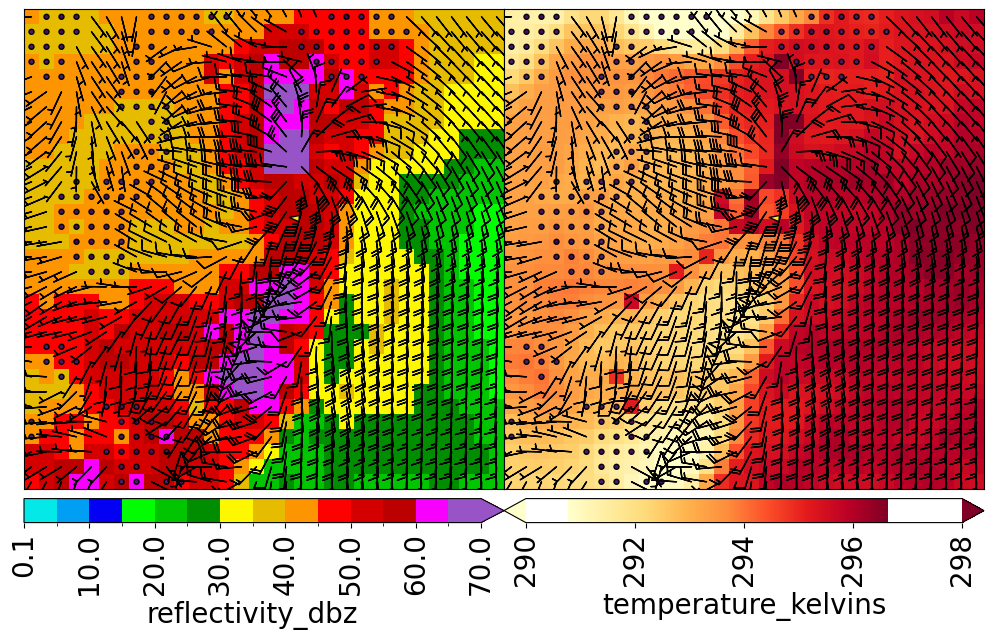

In [8]:
target_matrix_s01 = validation_image_dict[image_utils.TARGET_MATRIX_KEY]
example_index = numpy.unravel_index(
    numpy.argmax(target_matrix_s01), target_matrix_s01.shape
)[0]

predictor_matrix = validation_image_dict[image_utils.PREDICTOR_MATRIX_KEY][
    example_index, ...
]
predictor_names = validation_image_dict[image_utils.PREDICTOR_NAMES_KEY]

temperature_matrix_kelvins = predictor_matrix[
    ..., predictor_names.index(image_utils.TEMPERATURE_NAME)
]
min_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 1)
max_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 99)

image_plotting.plot_many_predictors_with_barbs(
    predictor_matrix=predictor_matrix, predictor_names=predictor_names,
    min_colour_temp_kelvins=min_temp_kelvins,
    max_colour_temp_kelvins=max_temp_kelvins
)

pyplot.show()

## Plot random example without wind barbs

 - The next cell plots a random example without wind barbs.
 - In this case, the wind field is plotted as two scalar fields ($u$-wind and $v$-wind).
 - This plotting format will be used when interpretation quantities (represented by line contours) are overlain on the predictors.

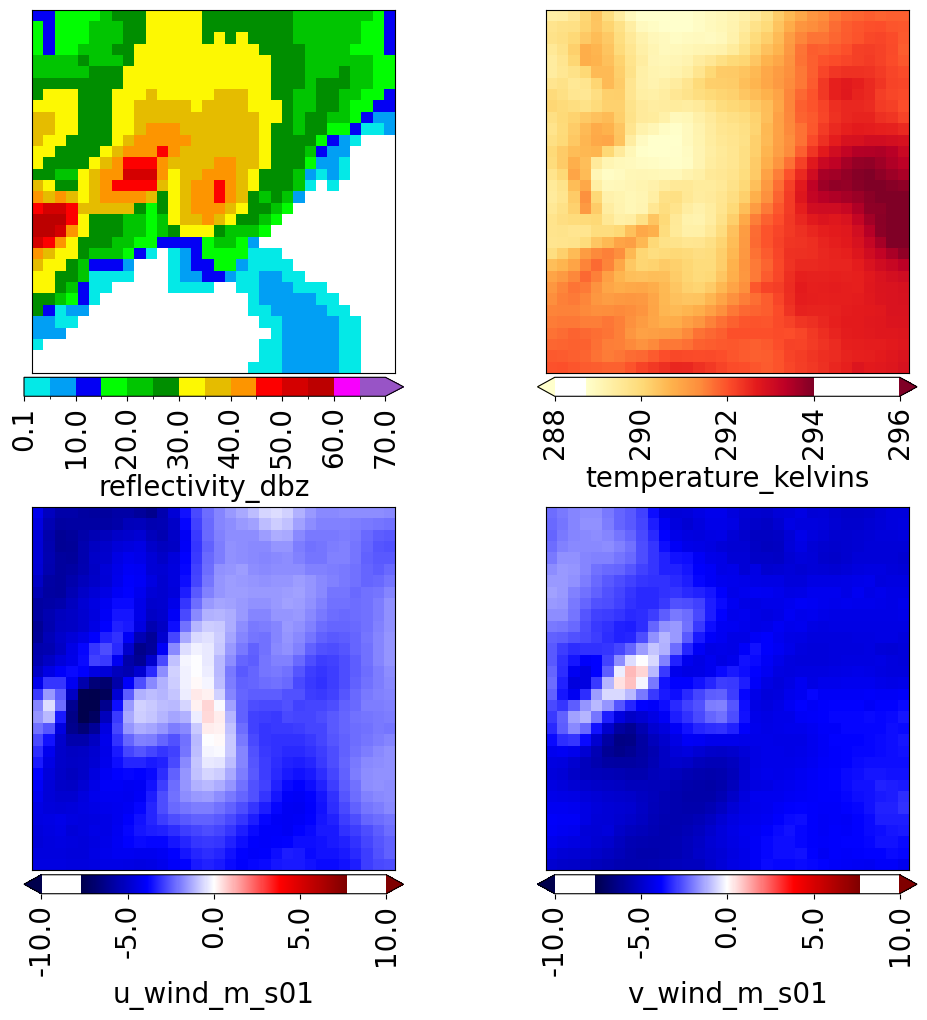

In [ ]:
predictor_matrix = (
    validation_image_dict[image_utils.PREDICTOR_MATRIX_KEY]
)
predictor_names = validation_image_dict[image_utils.PREDICTOR_NAMES_KEY]

num_examples = predictor_matrix.shape[0]
random_index = random.randint(0, num_examples - 1)
predictor_matrix = predictor_matrix[random_index, ...]

temperature_matrix_kelvins = predictor_matrix[
    ..., predictor_names.index(image_utils.TEMPERATURE_NAME)
]
min_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 1)
max_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 99)

wind_speed_matrix_m_s01 = numpy.sqrt(
    predictor_matrix[..., predictor_names.index(image_utils.U_WIND_NAME)] ** 2 +
    predictor_matrix[..., predictor_names.index(image_utils.V_WIND_NAME)] ** 2
)
max_speed_m_s01 = numpy.percentile(
    numpy.absolute(wind_speed_matrix_m_s01), 99
)

image_plotting.plot_many_predictors_sans_barbs(
    predictor_matrix=predictor_matrix, predictor_names=predictor_names,
    min_colour_temp_kelvins=min_temp_kelvins,
    max_colour_temp_kelvins=max_temp_kelvins,
    max_colour_wind_speed_m_s01=max_speed_m_s01
)

pyplot.show()

## Plot strong example without wind barbs

The next cell plots the strongest example in the validation data (that with the greatest max future vorticity), using scalar fields instead of wind barbs.

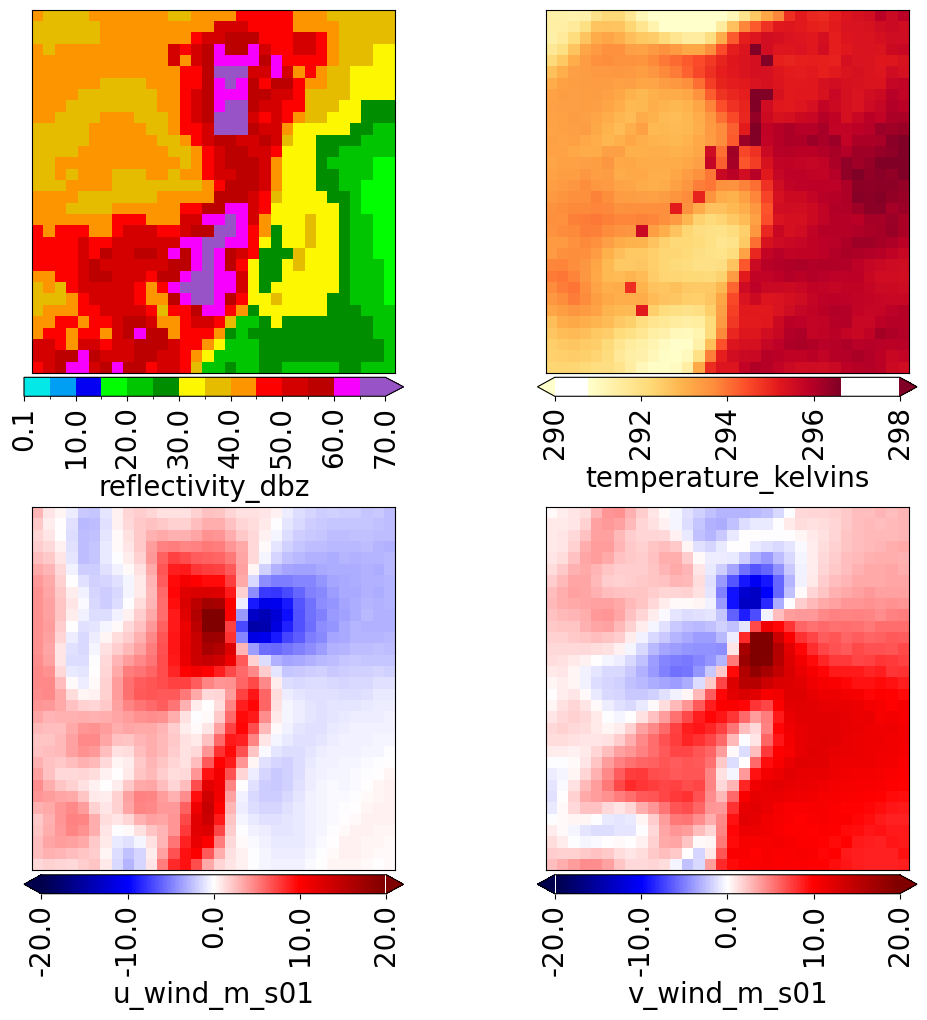

In [ ]:
target_matrix_s01 = validation_image_dict[image_utils.TARGET_MATRIX_KEY]
example_index = numpy.unravel_index(
    numpy.argmax(target_matrix_s01), target_matrix_s01.shape
)[0]

predictor_matrix = validation_image_dict[image_utils.PREDICTOR_MATRIX_KEY][
    example_index, ...
]
predictor_names = validation_image_dict[image_utils.PREDICTOR_NAMES_KEY]

temperature_matrix_kelvins = predictor_matrix[
    ..., predictor_names.index(image_utils.TEMPERATURE_NAME)
]
min_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 1)
max_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 99)

wind_speed_matrix_m_s01 = numpy.sqrt(
    predictor_matrix[..., predictor_names.index(image_utils.U_WIND_NAME)] ** 2 +
    predictor_matrix[..., predictor_names.index(image_utils.V_WIND_NAME)] ** 2
)
max_speed_m_s01 = numpy.percentile(
    numpy.absolute(wind_speed_matrix_m_s01), 99
)

image_plotting.plot_many_predictors_sans_barbs(
    predictor_matrix=predictor_matrix, predictor_names=predictor_names,
    min_colour_temp_kelvins=min_temp_kelvins,
    max_colour_temp_kelvins=max_temp_kelvins,
    max_colour_wind_speed_m_s01=max_speed_m_s01
)

pyplot.show()

# <font color='red'>Find normalization parameters (required)</font>

- The next cell finds normalization parameters for each predictor variable.
- Normalization parameters must be based on the training data only.
- For $z$-score normalization, the parameters are mean and standard deviation.
<br><br>

- In traditional ML, the input data would be tabular ($N$ scalar predictor variables for each storm object).
- Here, the input data are spatial imagery (4 predictor variables, on a 32-by-32 grid, for each storm object).
- However, we still compute one mean and standard deviation for each predictor, rather than one for each predictor and grid cell.
- Thus, the mean and standard deviation for each predictor are based on data from all training examples and all 1024 grid cells.
<br><br>

- We will not normalize the data right away.
- We will plot the data frequently throughout this notebook, and we want to plot variables in physical space rather than normalized space.
- However, we will store the normalization parameters and use them when feeding data into a CNN.

In [7]:
normalization_dict = image_normalization.get_normalization_params(
    image_dict=training_image_dict
)

## Sanity check

- The next cell normalizes, and then denormalizes, a small amount of testing data.
- Normalized values should be small positive or negative numbers (mostly from $-3\ldots+3$).
- Denormalized values must equal original (physical) values.

In [ ]:
predictor_names = testing_image_dict[image_utils.PREDICTOR_NAMES_KEY]
original_values = (
    testing_image_dict[image_utils.PREDICTOR_MATRIX_KEY][0, :5, :5, 0]
)

print('\nOriginal values of {0:s} for first storm object:\n{1:s}'.format(
    predictor_names[0], str(original_values)
))

testing_image_dict[image_utils.PREDICTOR_MATRIX_KEY], _ = (
    image_normalization.normalize_data(
        predictor_matrix=testing_image_dict[image_utils.PREDICTOR_MATRIX_KEY],
        predictor_names=predictor_names,
        normalization_dict=normalization_dict
    )
)

normalized_values = (
    testing_image_dict[image_utils.PREDICTOR_MATRIX_KEY][0, :5, :5, 0]
)
print((
    '\nNormalized values of {0:s} for first storm object:\n{1:s}'
).format(
    predictor_names[0], str(normalized_values)
))

testing_image_dict[image_utils.PREDICTOR_MATRIX_KEY] = (
    image_normalization.denormalize_data(
        predictor_matrix=testing_image_dict[image_utils.PREDICTOR_MATRIX_KEY],
        predictor_names=predictor_names,
        normalization_dict=normalization_dict
    )
)

denormalized_values = (
    testing_image_dict[image_utils.PREDICTOR_MATRIX_KEY][0, :5, :5, 0]
)
print((
    '\nDenormalized values of {0:s} for first storm object:\n{1:s}'
).format(
    predictor_names[0], str(denormalized_values)
))

NameError: name 'testing_image_dict' is not defined

# The CRPS loss function (CRPS-LF) approach

This section implements the CRPS-LF approach for uncertainty quantification.

## Theory

Add stuff here.

## Setup

The next cell sets up a CRPS-LF convolutional neural network (CNN) with the following hyperparameters:

 - 4 convolutional blocks
 - 2 convolutional layers per block
 - Dropout rate for conv layers and output layer = 0
 - Dropout rate for non-terminal dense layers = 0.5
 - Activation function for conv layers and non-terminal dense layers = leaky ReLU with slope of 0.2
 - Activation function for output layer = strict ReLU (slope of 0.0)
 - L$_2$ regularization (strength of 0.001) for all convolutional layers
 - Ensemble size of 100 `max_future_vorticity` predictions, constrained with CRPS loss function

In [9]:
loss_function = custom_losses.CRPS(function_name='crps_loss', diversity_weight=0.)

metric_functions = [
    custom_metrics.MeanSquaredError(function_name='mse'),
    custom_metrics.MeanAbsoluteError(function_name='mae'),
    custom_metrics.MeanAbsPairwiseDiff(function_name='mapd'),
    custom_metrics.CRPS(function_name='crps', diversity_weight=0.),
]

crps_lf_model_object = crps_lf.setup_cnn(
    loss_function=loss_function,
    metric_functions=metric_functions,
    use_batch_normalization=True,
    dense_layer_neuron_counts=numpy.array([776, 147, 100, 100, 100], dtype=int),
    l2_weight=1e-6
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             

 Total params: 4,509,367 (17.20 MB)

 Trainable params: 4,505,201 (17.19 MB)

 Non-trainable params: 4,166 (16.27 KB)

## Training

The next cell trains the CNN we just created.

In [9]:
neural_net.train_model_sans_generator(
    model_object=crps_lf_model_object,
    training_file_names=training_file_names,
    validation_file_names=validation_file_names,
    normalization_dict=normalization_dict,
    num_epochs=100,
    num_examples_per_batch=1024,
    save_weights_every_epoch=False,
    output_dir_name='/content/models/crps_lf'
)

Reading data from: "/content/data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20101024-0000_d01_model_patches.nc"...
Reading data from: "/content/data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20101122-0000_d01_model_patches.nc"...
Reading data from: "/content/data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110201-0000_d01_model_patches.nc"...
Reading data from: "/content/data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110308-0000_d01_model_patches.nc"...
Reading data from: "/content/data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110326-0000_d01_model_patches.nc"...
Reading data from: "/content/data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110404-0000_d01_model_patches.nc"...
Reading data from: "/content/data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110414-0000_d01_model_patches.nc"...
Reading data from: "/content/data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110420-0000_d01_model_patches.nc"...
Reading data from: "/content/data/track_data_ncar_ams_3km_nc_small/NCARS

KeyboardInterrupt: 

## Evaluation on training data

The next cell evaluates the CRPS-LF model on training data.

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 32)     │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_24 (LeakyReLU)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_25 (LeakyReLU)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_26 (LeakyReLU)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_27 (LeakyReLU)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_28 (LeakyReLU)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_29 (LeakyReLU)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 128)      │             

 Total params: 4,509,367 (17.20 MB)

 Trainable params: 4,505,201 (17.19 MB)

 Non-trainable params: 4,166 (16.27 KB)

Applying model to examples 1-1000 of 21531...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
Applying model to examples 1001-2000 of 21531...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
Applying model to examples 2001-3000 of 21531...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Applying model to examples 3001-4000 of 21531...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Applying model to examples 4001-5000 of 21531...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Applying model to examples 5001-6000 of 21531...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Applying model to examples 6001-7000 of 21531...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Applying model to examples 7001-8000 of 21531...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Applying model to examples 8001-9000 of 21531...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Applying model to examples 9001-10000 of 21531...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Applying model to examples 10001-11000 of 21531...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Applying model to examples 11001-12000 of 21531...

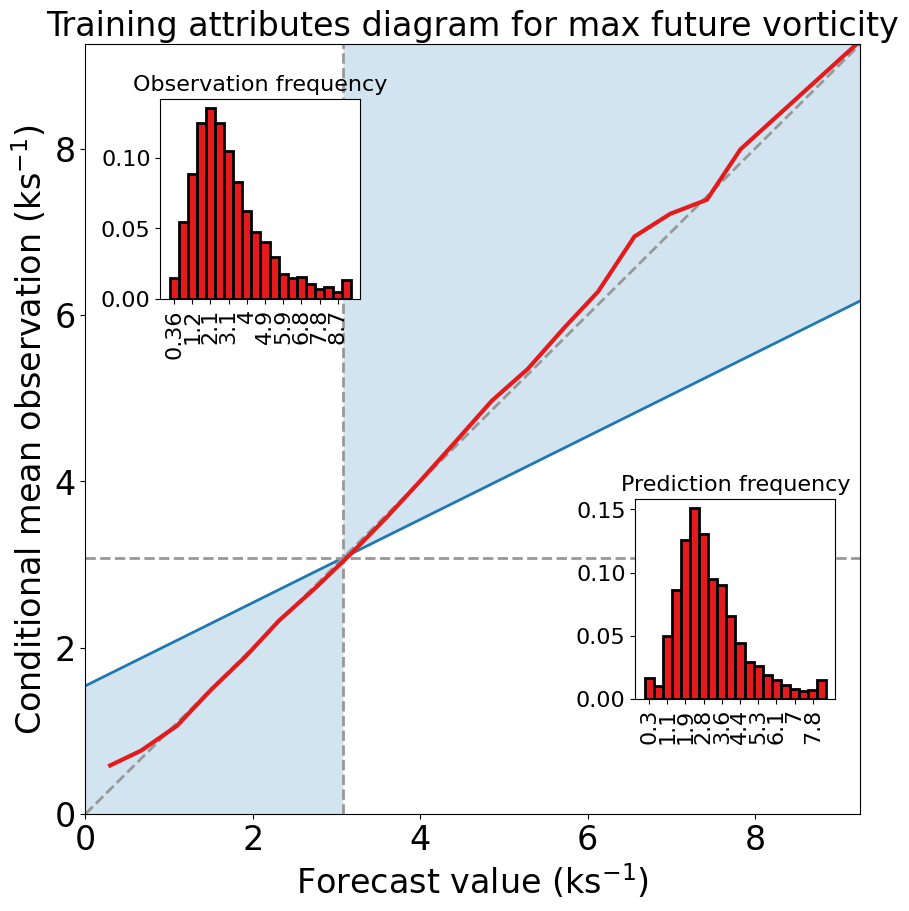



**************************************************




**************************************************




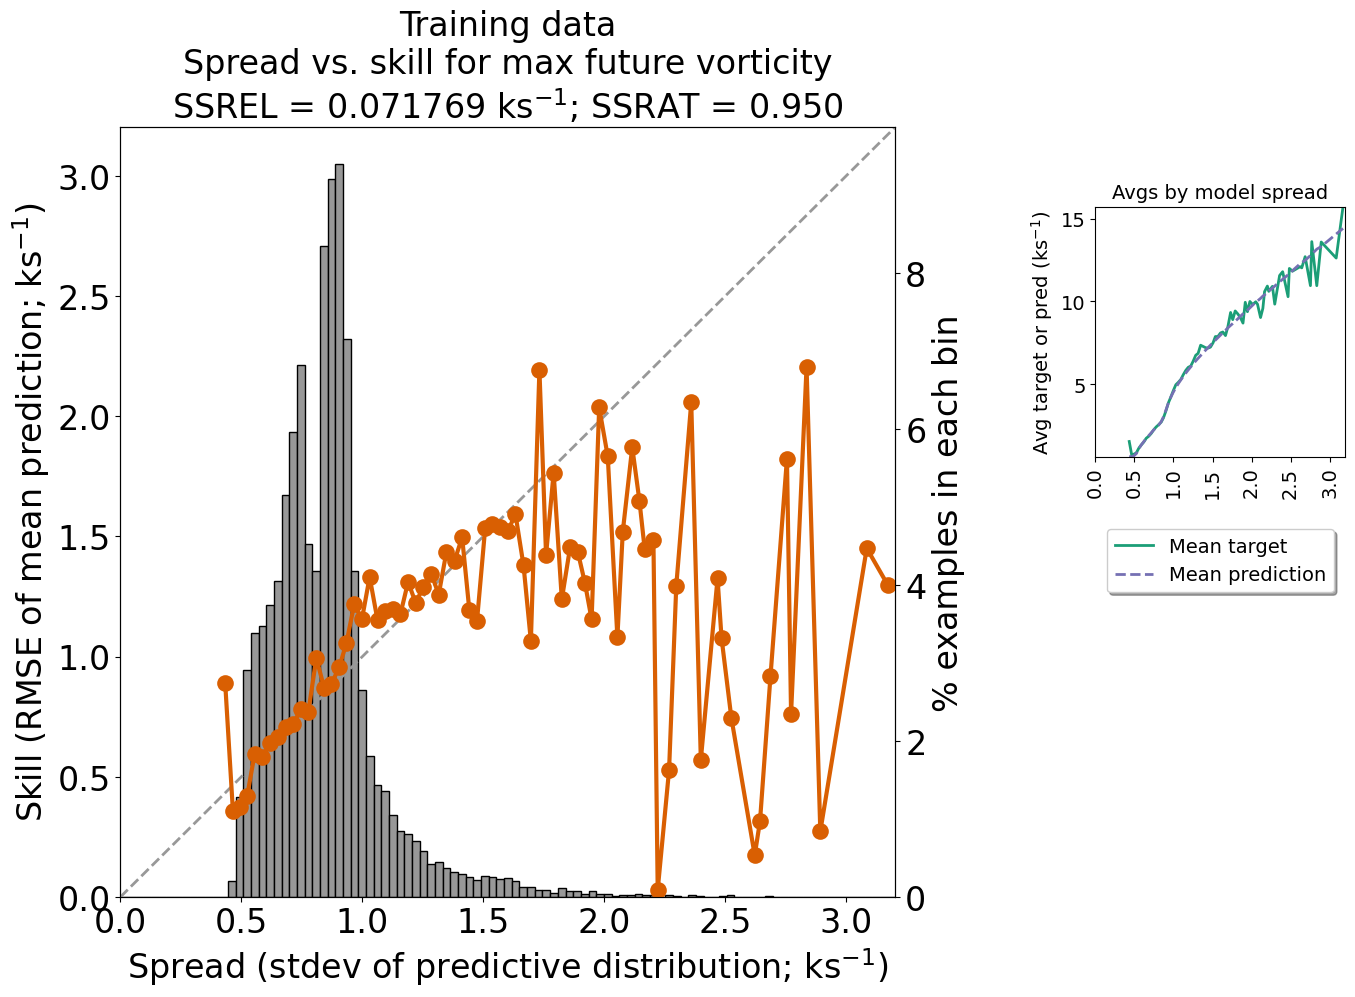



**************************************************




**************************************************




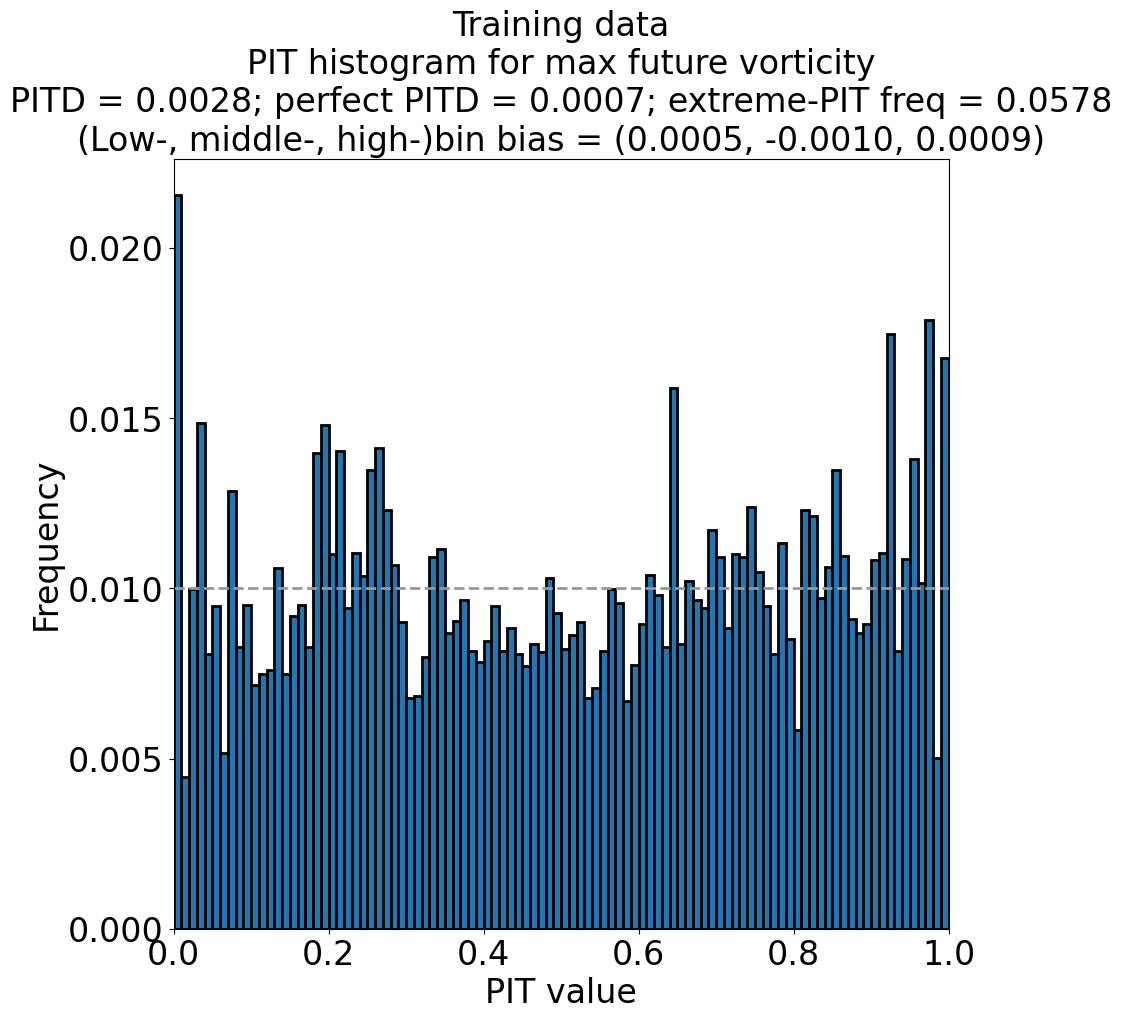



**************************************************




**************************************************




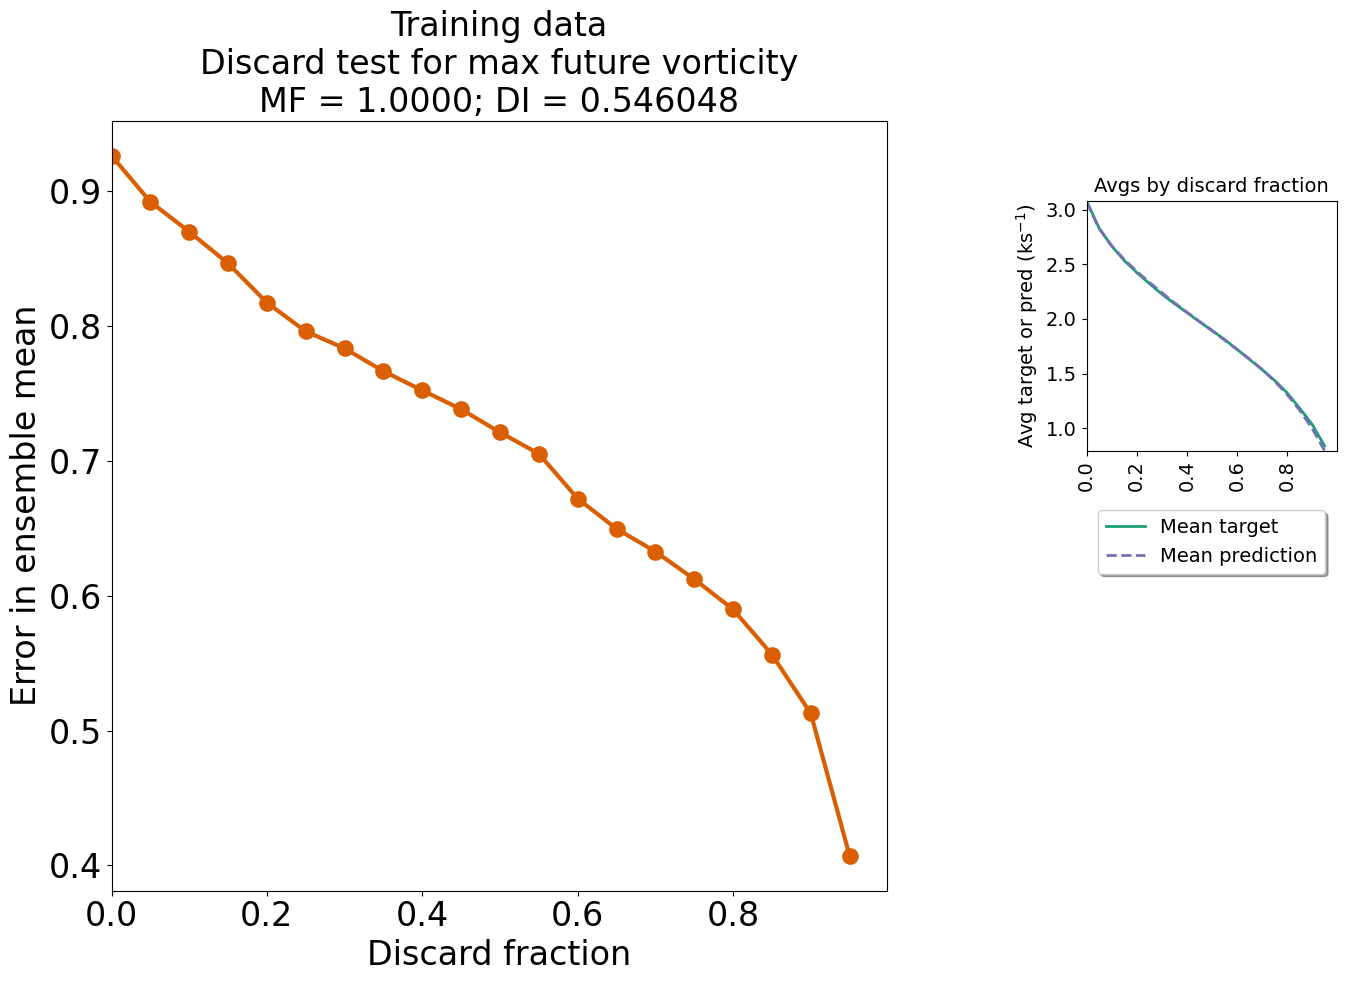

In [11]:
# Read the trained model weights.
crps_lf_model_object = crps_lf.setup_cnn(
    loss_function=loss_function,
    metric_functions=metric_functions,
    use_batch_normalization=True,
    dense_layer_neuron_counts=numpy.array([776, 147, 100, 100, 100], dtype=int),
    l2_weight=1e-6
)
crps_lf_model_object = neural_net.read_model_weights(
    model_object=crps_lf_model_object,
    hdf5_file_name='/content/models/crps_lf/model_epoch=0055_val-loss=0.53982.weights.h5'
)

# Apply the model to training data.
training_norm_predictor_matrix, _ = image_normalization.normalize_data(
    predictor_matrix=copy.deepcopy(
        training_image_dict[image_utils.PREDICTOR_MATRIX_KEY]
    ),
    predictor_names=training_image_dict[image_utils.PREDICTOR_NAMES_KEY],
    normalization_dict=normalization_dict
)
training_target_values = numpy.max(
    training_image_dict[image_utils.TARGET_MATRIX_KEY],
    axis=(1, 2)
)
training_prediction_matrix = neural_net.apply_model(
    model_object=crps_lf_model_object,
    predictor_matrix=training_norm_predictor_matrix
)
print(SEPARATOR_STRING)
print(SEPARATOR_STRING)

# Evaluate the ensemble mean first.
utils.evaluate_regression(
    actual_values=training_target_values,
    predicted_values=numpy.mean(training_prediction_matrix, axis=-1),
    mean_training_target_value=numpy.mean(training_target_values),
    verbose=True,
    create_plots=True,
    dataset_name='Training'
)
print(SEPARATOR_STRING)
print(SEPARATOR_STRING)

# Compute and display the spread-skill plot.
training_stdevs = numpy.std(training_prediction_matrix, axis=-1, ddof=1)
bin_edge_prediction_stdevs = numpy.linspace(
    0, numpy.max(training_stdevs), num=101, dtype=float
)
bin_edge_prediction_stdevs = bin_edge_prediction_stdevs[1:-1]
training_ss_dict = spread_skill_utils.get_results_one_var(
    target_values=training_target_values,
    prediction_matrix=training_prediction_matrix,
    bin_edge_prediction_stdevs=bin_edge_prediction_stdevs
)
spread_skill_utils.plot_spread_vs_skill(
    result_dict=training_ss_dict,
    model_description_string='Training data'
)
pyplot.show()
print(SEPARATOR_STRING)
print(SEPARATOR_STRING)

# Compute and display the PIT histogram.
training_pit_dict = pit_utils.get_histogram_one_var(
    target_values=training_target_values,
    prediction_matrix=training_prediction_matrix,
    num_bins=100
)
pit_utils.plot_pit_histogram(
    result_dict=training_pit_dict,
    model_description_string='Training data'
)
pyplot.show()
print(SEPARATOR_STRING)
print(SEPARATOR_STRING)

# Compute and display the discard test.
training_discard_dict = discard_test_utils.run_discard_test(
    target_values=training_target_values,
    prediction_matrix=training_prediction_matrix,
    discard_fractions=numpy.linspace(0.05, 0.95, num=19),
    error_function=discard_test_utils.get_rmse_error_function(),
    uncertainty_function=discard_test_utils.get_stdev_uncertainty_function()
)
discard_test_utils.plot_discard_test(
    result_dict=training_discard_dict,
    model_description_string='Training data'
)
pyplot.show()

## Evaluation on validation data

Applying model to examples 1-1000 of 25392...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Applying model to examples 1001-2000 of 25392...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Applying model to examples 2001-3000 of 25392...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Applying model to examples 3001-4000 of 25392...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Applying model to examples 4001-5000 of 25392...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Applying model to examples 5001-6000 of 25392...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Applying model to examples 6001-7000 of 25392...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Applying model to examples 7001-8000 of 25392...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Applying model to examples 8001-9000 of 25392...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Applying model to examples 9001-10000 of 25392...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Applying model to examples 10001-11000 of 25392...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Applying model to examples 11001-12000 of 2

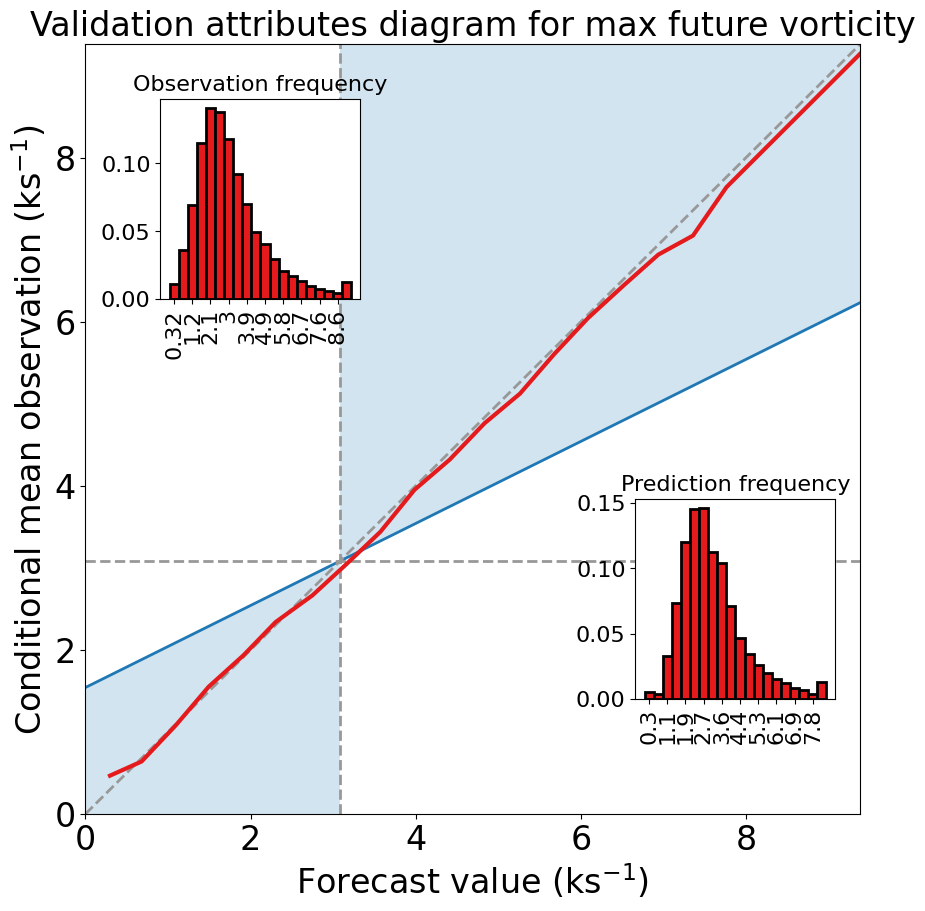



**************************************************




**************************************************




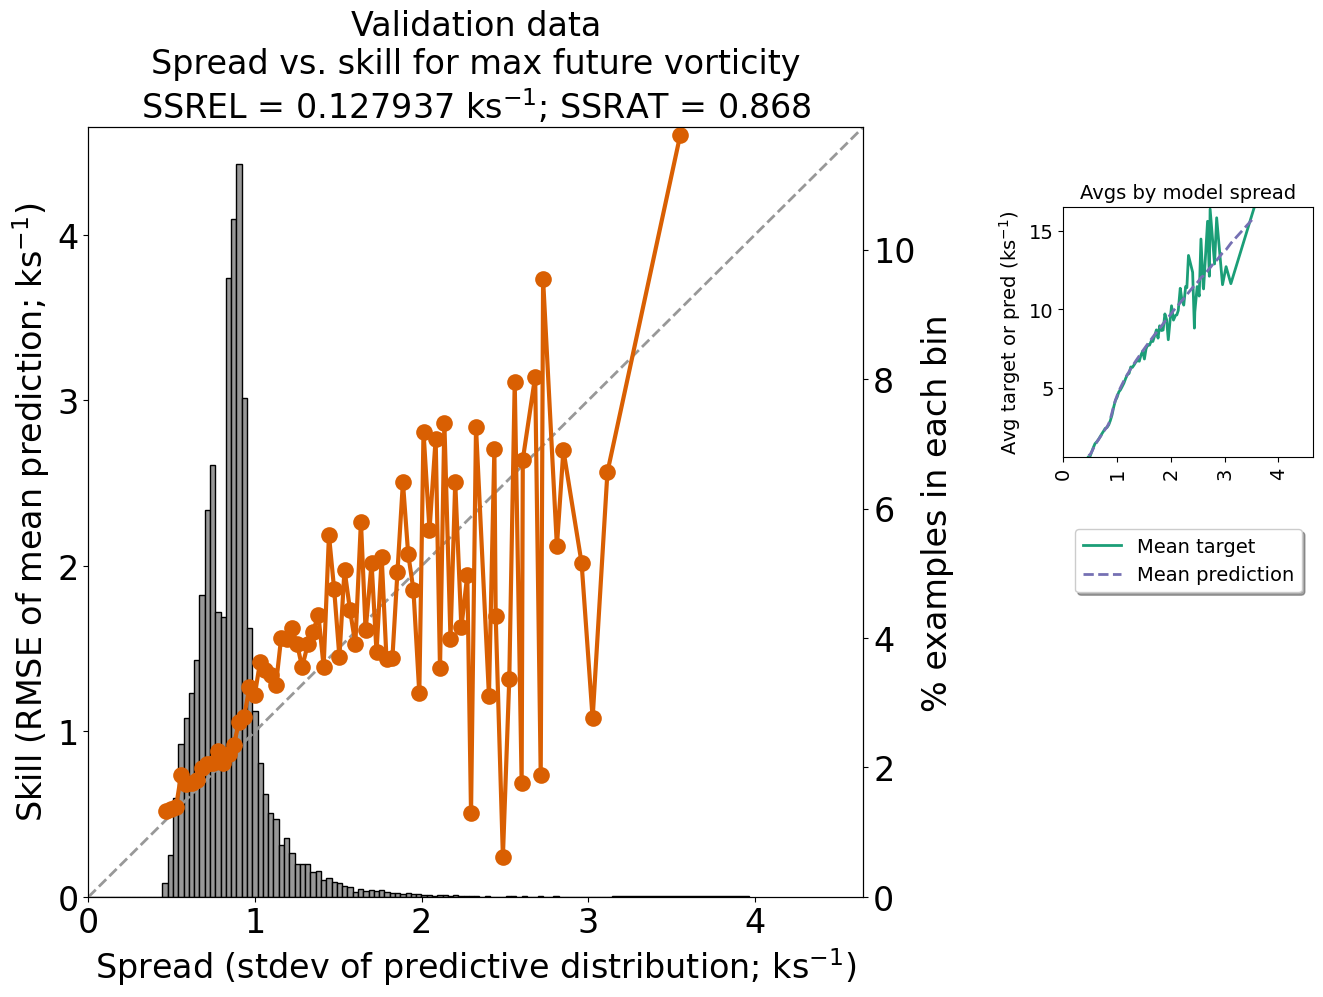



**************************************************




**************************************************




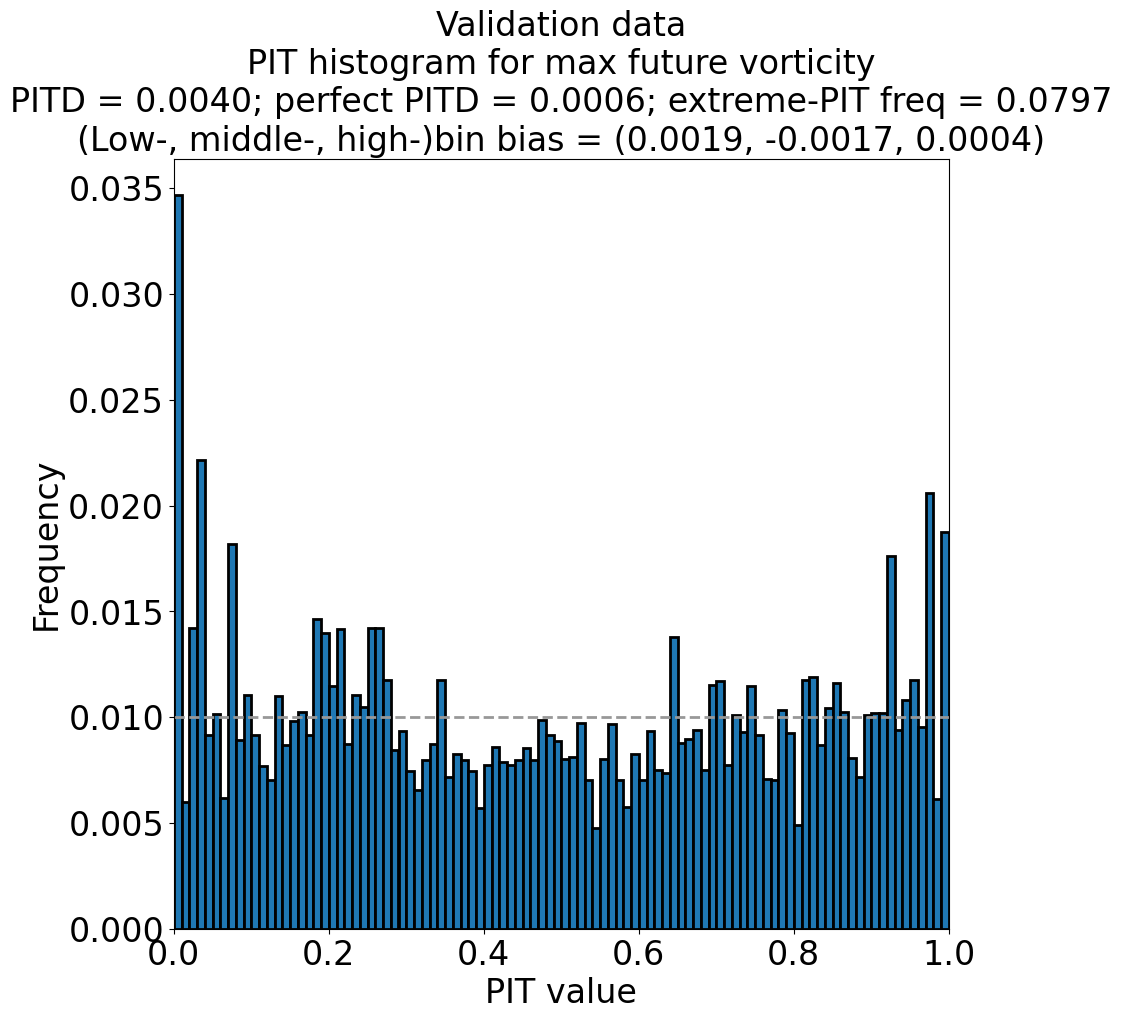



**************************************************




**************************************************




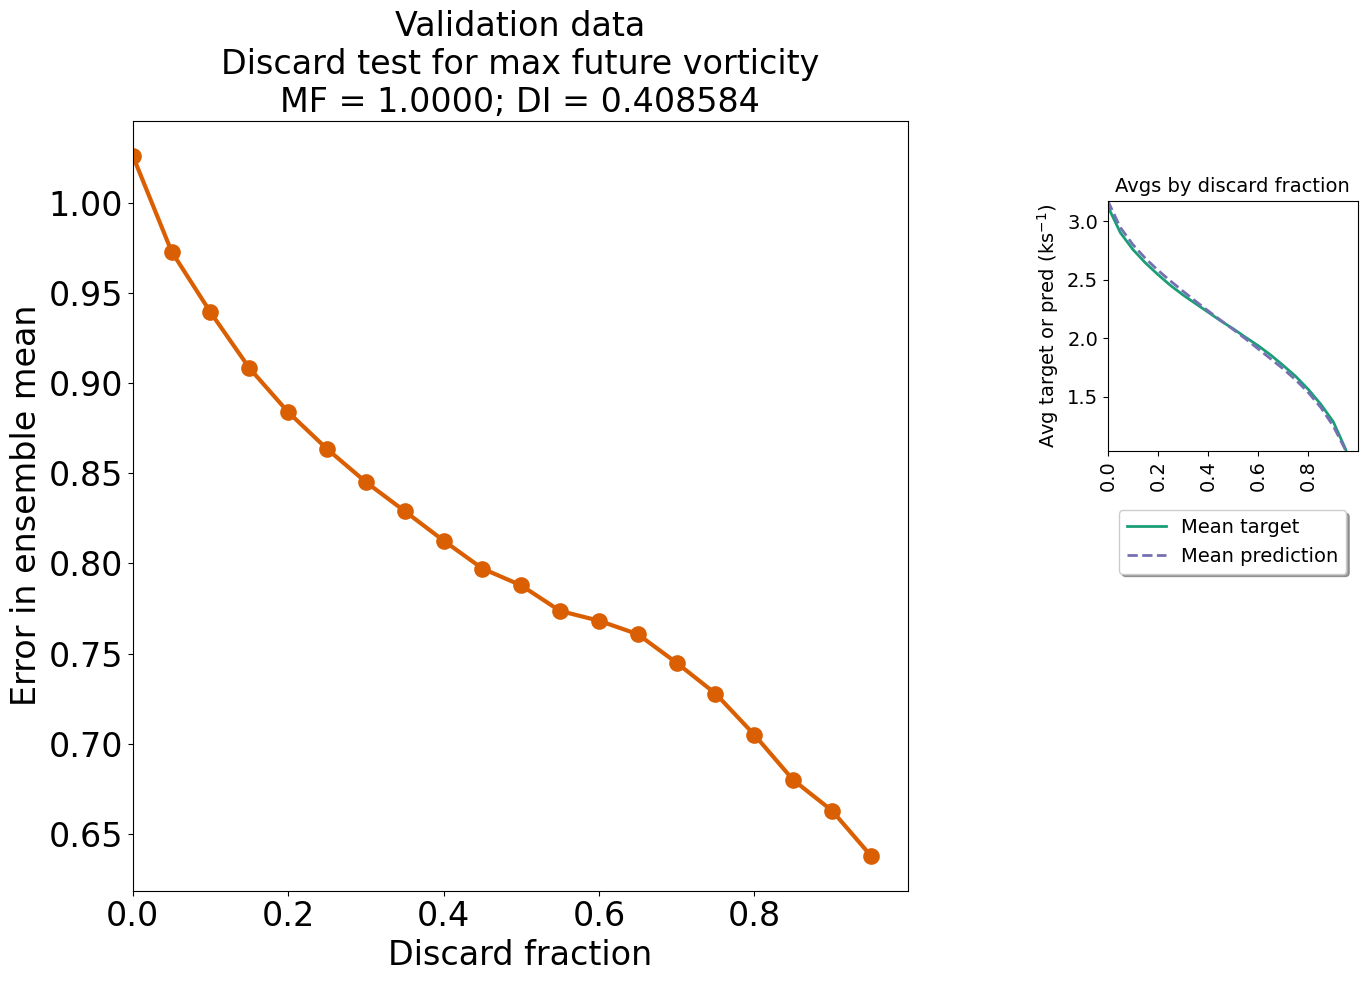

In [12]:
# Apply the model to validation data.
validation_norm_predictor_matrix, _ = image_normalization.normalize_data(
    predictor_matrix=copy.deepcopy(
        validation_image_dict[image_utils.PREDICTOR_MATRIX_KEY]
    ),
    predictor_names=validation_image_dict[image_utils.PREDICTOR_NAMES_KEY],
    normalization_dict=normalization_dict
)
validation_target_values = numpy.max(
    validation_image_dict[image_utils.TARGET_MATRIX_KEY],
    axis=(1, 2)
)
validation_prediction_matrix = neural_net.apply_model(
    model_object=crps_lf_model_object,
    predictor_matrix=validation_norm_predictor_matrix
)
print(SEPARATOR_STRING)
print(SEPARATOR_STRING)

# Evaluate the ensemble mean first.
utils.evaluate_regression(
    actual_values=validation_target_values,
    predicted_values=numpy.mean(validation_prediction_matrix, axis=-1),
    mean_training_target_value=numpy.mean(training_target_values),
    verbose=True,
    create_plots=True,
    dataset_name='Validation'
)
print(SEPARATOR_STRING)
print(SEPARATOR_STRING)

# Compute and display the spread-skill plot.
validation_ss_dict = spread_skill_utils.get_results_one_var(
    target_values=validation_target_values,
    prediction_matrix=validation_prediction_matrix,
    bin_edge_prediction_stdevs=bin_edge_prediction_stdevs
)
spread_skill_utils.plot_spread_vs_skill(
    result_dict=validation_ss_dict,
    model_description_string='Validation data'
)
pyplot.show()
print(SEPARATOR_STRING)
print(SEPARATOR_STRING)

# Compute and display the PIT histogram.
validation_pit_dict = pit_utils.get_histogram_one_var(
    target_values=validation_target_values,
    prediction_matrix=validation_prediction_matrix,
    num_bins=100
)
pit_utils.plot_pit_histogram(
    result_dict=validation_pit_dict,
    model_description_string='Validation data'
)
pyplot.show()
print(SEPARATOR_STRING)
print(SEPARATOR_STRING)

# Compute and display the discard test.
validation_discard_dict = discard_test_utils.run_discard_test(
    target_values=validation_target_values,
    prediction_matrix=validation_prediction_matrix,
    discard_fractions=numpy.linspace(0.05, 0.95, num=19),
    error_function=discard_test_utils.get_rmse_error_function(),
    uncertainty_function=discard_test_utils.get_stdev_uncertainty_function()
)
discard_test_utils.plot_discard_test(
    result_dict=validation_discard_dict,
    model_description_string='Validation data'
)
pyplot.show()

# The parametric distributional prediction (PDP) approach

This section implements the PDP approach for uncertainty quantification.

## Theory

Add stuff here.

## Setup

The next cell sets up a PDP neural network with almost the exact same hyperparameters as the CRPS-LF network.  The only difference is that, while the CRPS-LF network had 100 output neurons (corresponding to 100 ensemble members), the PDP network has 2 output neurons (corresponding to the mean and standard deviation of an assumed Gaussian distribution).  Also, the loss function is slightly different.  The CRPS-LF network uses the ensemble formulation of the CRPS, while the PDP network uses a formulation that assumes a Gaussian distribution.

In [13]:
loss_function = custom_losses.CRPSGaussian(function_name='crps_loss')

metric_functions = [
    custom_metrics.MSEGaussian(function_name='mse'),
    custom_metrics.MAEGaussian(function_name='mae'),
    custom_metrics.CRPSGaussian(function_name='crps'),
]

pdp_model_object = crps_lf.setup_cnn(
    loss_function=loss_function,
    metric_functions=metric_functions,
    use_batch_normalization=True,
    dense_layer_neuron_counts=numpy.array([776, 147, 28, 5, 2], dtype=int),
    l2_weight=1e-6
)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 32, 32, 32)     │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_36 (LeakyReLU)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_37 (LeakyReLU)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_38 (LeakyReLU)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_39 (LeakyReLU)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_40 (LeakyReLU)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_41 (LeakyReLU)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 4, 4, 128)      │             

 Total params: 4,478,000 (17.08 MB)

 Trainable params: 4,474,168 (17.07 MB)

 Non-trainable params: 3,832 (14.97 KB)

## Training

The next cell trains the PDP neural network.

In [16]:
neural_net.train_model_sans_generator(
    model_object=pdp_model_object,
    training_file_names=training_file_names,
    validation_file_names=validation_file_names,
    normalization_dict=normalization_dict,
    num_epochs=100,
    num_examples_per_batch=1024,
    save_weights_every_epoch=False,
    output_dir_name='/content/models/pdp_model'
)

Reading data from: "/content/data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20101024-0000_d01_model_patches.nc"...
Reading data from: "/content/data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20101122-0000_d01_model_patches.nc"...
Reading data from: "/content/data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110201-0000_d01_model_patches.nc"...
Reading data from: "/content/data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110308-0000_d01_model_patches.nc"...
Reading data from: "/content/data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110326-0000_d01_model_patches.nc"...
Reading data from: "/content/data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110404-0000_d01_model_patches.nc"...
Reading data from: "/content/data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110414-0000_d01_model_patches.nc"...
Reading data from: "/content/data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110420-0000_d01_model_patches.nc"...
Reading data from: "/content/data/track_data_ncar_ams_3km_nc_small/NCARS

## Evaluation on training data

The next cell evaluates the PDP model on training data.

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 32, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 32, 32, 32)     │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_48 (LeakyReLU)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_49 (LeakyReLU)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_50 (LeakyReLU)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_51 (LeakyReLU)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_52 (LeakyReLU)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_53 (LeakyReLU)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 4, 4, 128)      │             

 Total params: 4,478,000 (17.08 MB)

 Trainable params: 4,474,168 (17.07 MB)

 Non-trainable params: 3,832 (14.97 KB)

Applying model to examples 1-1000 of 21531...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
Applying model to examples 1001-2000 of 21531...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
Applying model to examples 2001-3000 of 21531...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Applying model to examples 3001-4000 of 21531...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Applying model to examples 4001-5000 of 21531...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Applying model to examples 5001-6000 of 21531...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Applying model to examples 6001-7000 of 21531...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Applying model to examples 7001-8000 of 21531...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Applying model to examples 8001-9000 of 21531...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Applying model to examples 9001-10000 of 21531...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Applying model to examples 10001-11000 of 21531...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Applying model to examples 11001-12000 of 21531...

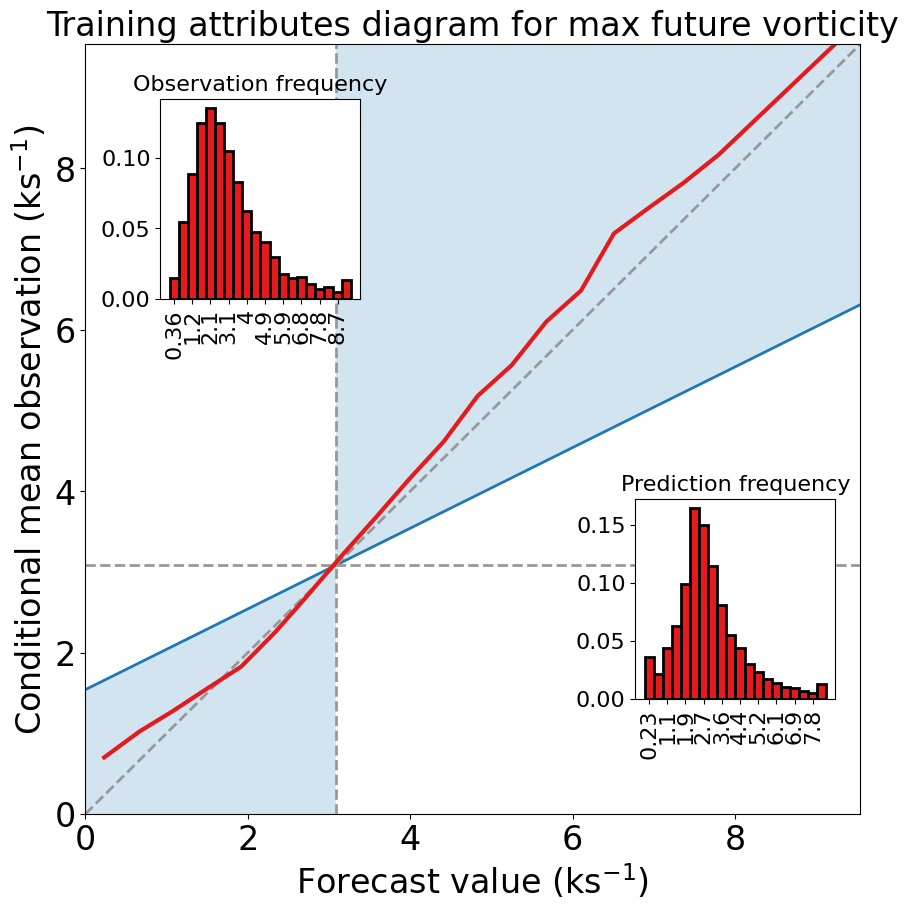



**************************************************




**************************************************




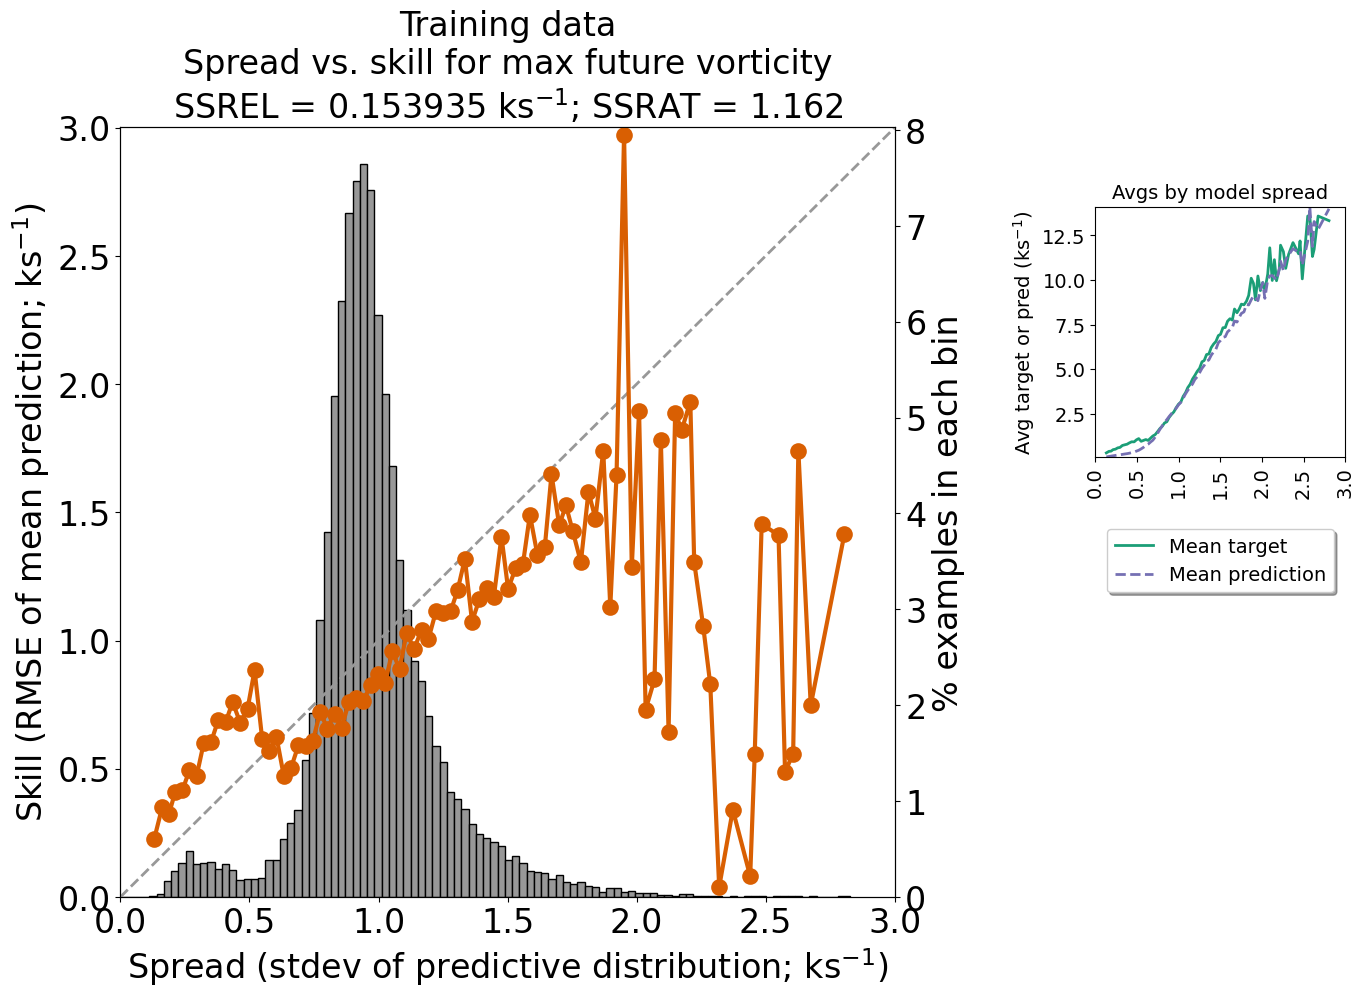



**************************************************




**************************************************




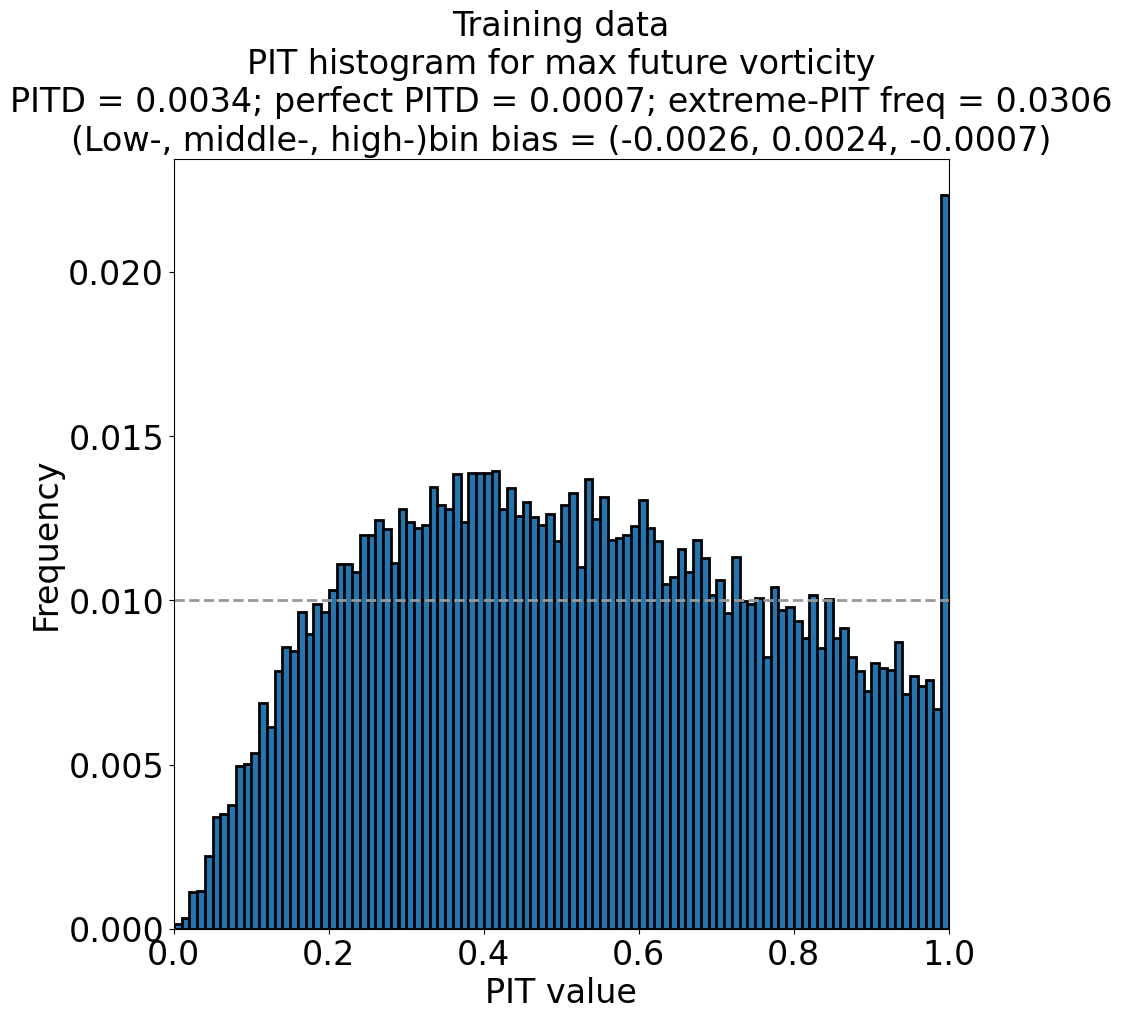



**************************************************




**************************************************




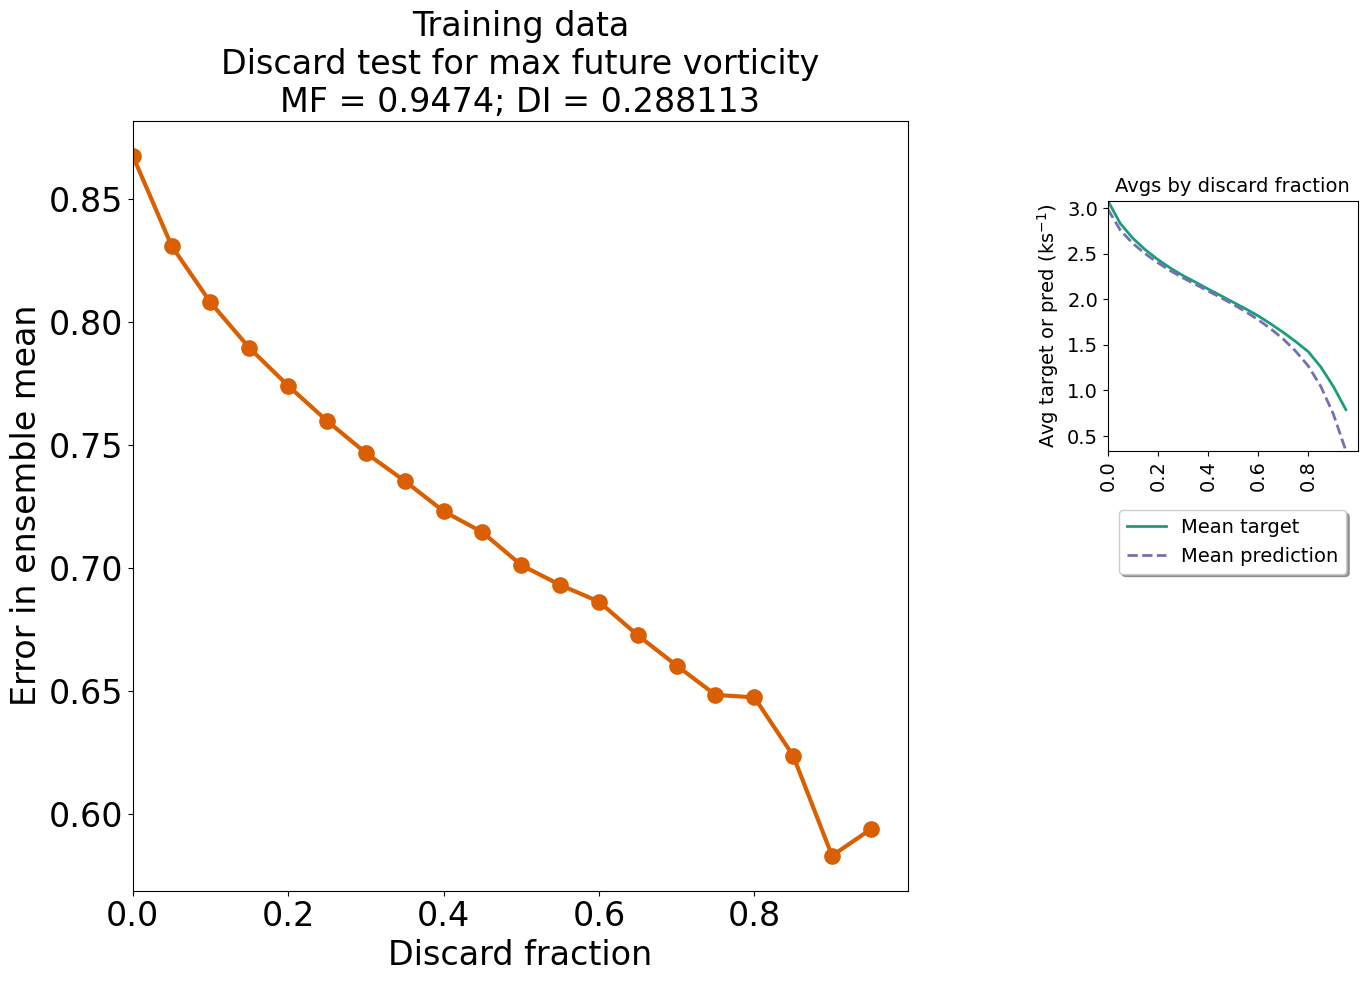

In [14]:
# Read the trained model weights.
pdp_model_object = crps_lf.setup_cnn(
    loss_function=loss_function,
    metric_functions=metric_functions,
    use_batch_normalization=True,
    dense_layer_neuron_counts=numpy.array([776, 147, 28, 5, 2], dtype=int),
    l2_weight=1e-6
)
pdp_model_object = neural_net.read_model_weights(
    model_object=pdp_model_object,
    hdf5_file_name='/content/models/pdp_model/model_epoch=0096_val-loss=0.55534.weights.h5'
)

# Apply the model to training data.
training_norm_predictor_matrix, _ = image_normalization.normalize_data(
    predictor_matrix=copy.deepcopy(
        training_image_dict[image_utils.PREDICTOR_MATRIX_KEY]
    ),
    predictor_names=training_image_dict[image_utils.PREDICTOR_NAMES_KEY],
    normalization_dict=normalization_dict
)
training_target_values = numpy.max(
    training_image_dict[image_utils.TARGET_MATRIX_KEY],
    axis=(1, 2)
)
training_prediction_matrix = neural_net.apply_model(
    model_object=pdp_model_object,
    predictor_matrix=training_norm_predictor_matrix
)
training_prediction_matrix = neural_net.convert_pdp_to_ensemble(
    prediction_matrix=training_prediction_matrix,
    ensemble_size=100
)
print(SEPARATOR_STRING)
print(SEPARATOR_STRING)

# Evaluate the ensemble mean first.
utils.evaluate_regression(
    actual_values=training_target_values,
    predicted_values=numpy.mean(training_prediction_matrix, axis=-1),
    mean_training_target_value=numpy.mean(training_target_values),
    verbose=True,
    create_plots=True,
    dataset_name='Training'
)
print(SEPARATOR_STRING)
print(SEPARATOR_STRING)

# Compute and display the spread-skill plot.
training_stdevs = numpy.std(training_prediction_matrix, axis=-1, ddof=1)
bin_edge_prediction_stdevs = numpy.linspace(
    0, numpy.max(training_stdevs), num=101, dtype=float
)
bin_edge_prediction_stdevs = bin_edge_prediction_stdevs[1:-1]
training_ss_dict = spread_skill_utils.get_results_one_var(
    target_values=training_target_values,
    prediction_matrix=training_prediction_matrix,
    bin_edge_prediction_stdevs=bin_edge_prediction_stdevs
)
spread_skill_utils.plot_spread_vs_skill(
    result_dict=training_ss_dict,
    model_description_string='Training data'
)
pyplot.show()
print(SEPARATOR_STRING)
print(SEPARATOR_STRING)

# Compute and display the PIT histogram.
training_pit_dict = pit_utils.get_histogram_one_var(
    target_values=training_target_values,
    prediction_matrix=training_prediction_matrix,
    num_bins=100
)
pit_utils.plot_pit_histogram(
    result_dict=training_pit_dict,
    model_description_string='Training data'
)
pyplot.show()
print(SEPARATOR_STRING)
print(SEPARATOR_STRING)

# Compute and display the discard test.
training_discard_dict = discard_test_utils.run_discard_test(
    target_values=training_target_values,
    prediction_matrix=training_prediction_matrix,
    discard_fractions=numpy.linspace(0.05, 0.95, num=19),
    error_function=discard_test_utils.get_rmse_error_function(),
    uncertainty_function=discard_test_utils.get_stdev_uncertainty_function()
)
discard_test_utils.plot_discard_test(
    result_dict=training_discard_dict,
    model_description_string='Training data'
)
pyplot.show()

## Evaluation on validation data

Applying model to examples 1-1000 of 25392...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Applying model to examples 1001-2000 of 25392...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Applying model to examples 2001-3000 of 25392...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Applying model to examples 3001-4000 of 25392...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Applying model to examples 4001-5000 of 25392...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Applying model to examples 5001-6000 of 25392...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Applying model to examples 6001-7000 of 25392...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Applying model to examples 7001-8000 of 25392...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Applying model to examples 8001-9000 of 25392...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Applying model to examples 9001-10000 of 25392...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Applying model to examples 10001-11000 of 25392...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Applying model to examples 11001-12000 of 25392...
1/1

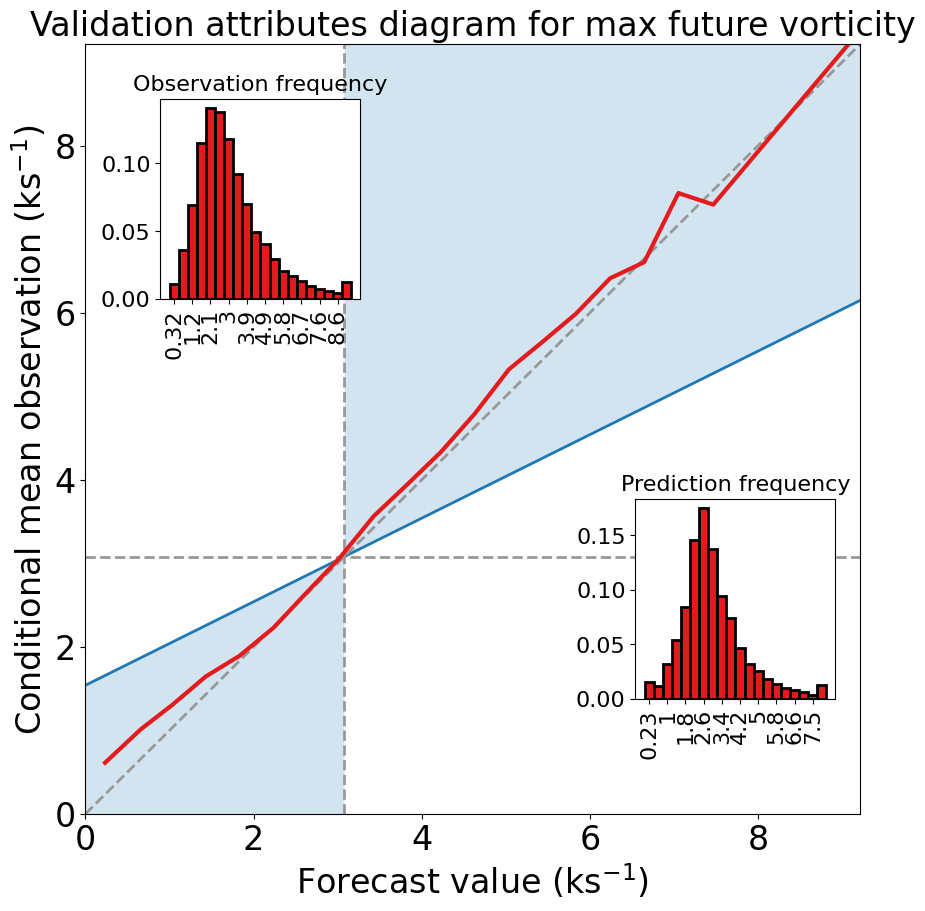



**************************************************




**************************************************




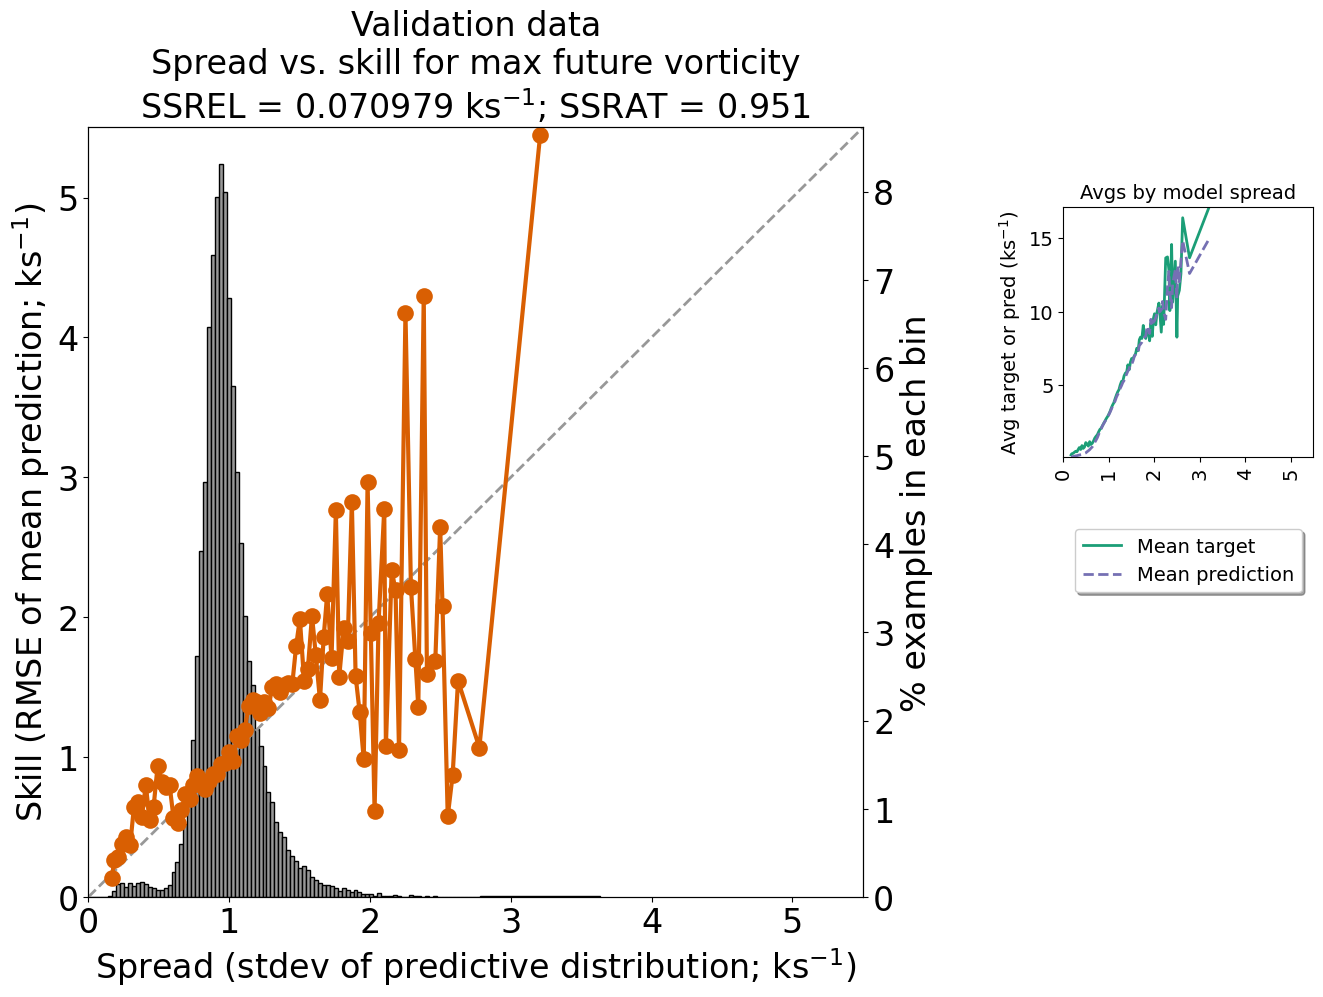



**************************************************




**************************************************




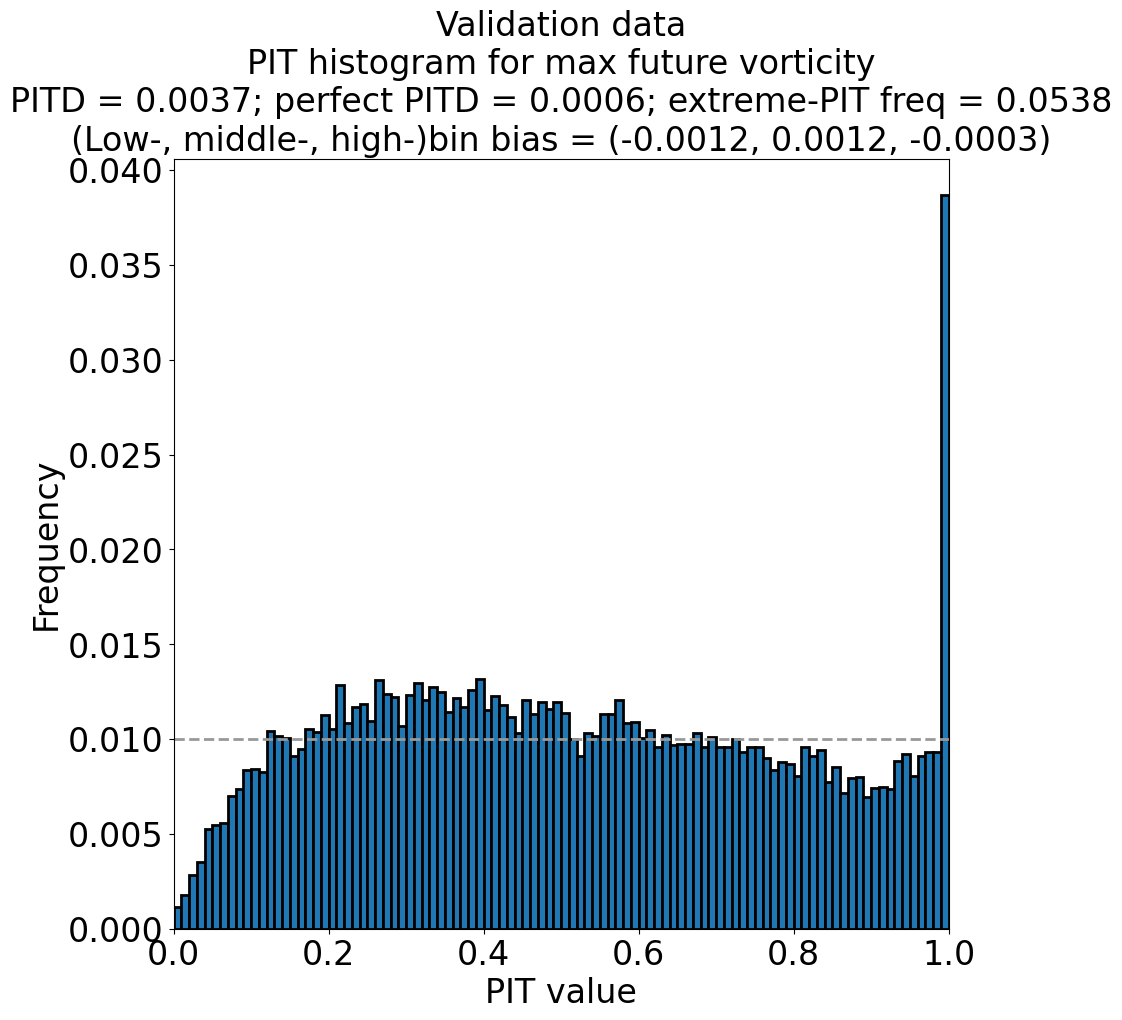



**************************************************




**************************************************




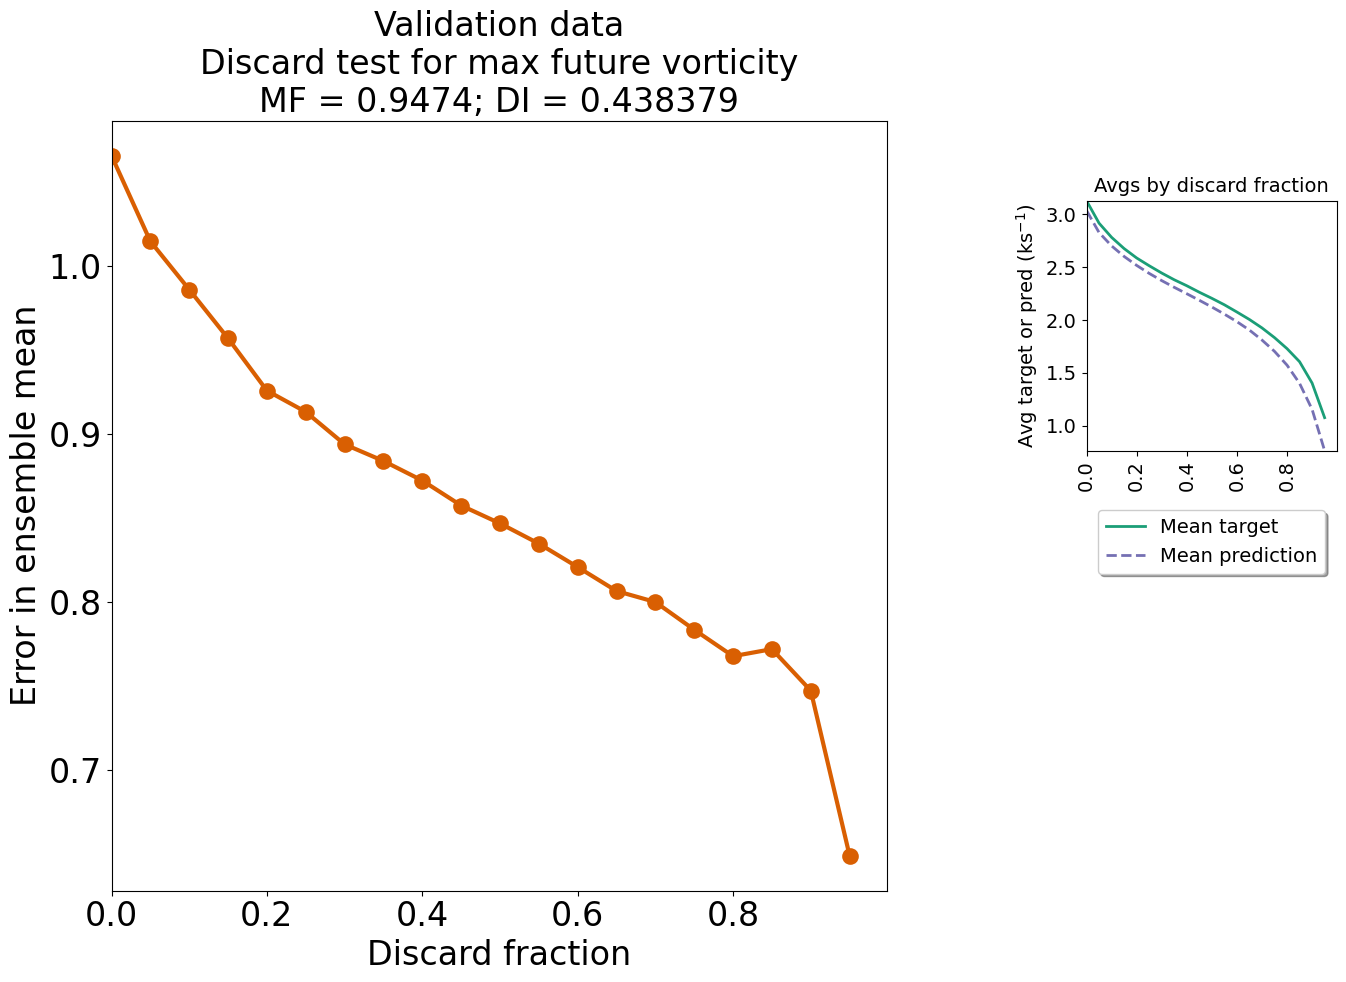

In [15]:
# Apply the model to validation data.
validation_norm_predictor_matrix, _ = image_normalization.normalize_data(
    predictor_matrix=copy.deepcopy(
        validation_image_dict[image_utils.PREDICTOR_MATRIX_KEY]
    ),
    predictor_names=validation_image_dict[image_utils.PREDICTOR_NAMES_KEY],
    normalization_dict=normalization_dict
)
validation_target_values = numpy.max(
    validation_image_dict[image_utils.TARGET_MATRIX_KEY],
    axis=(1, 2)
)
validation_prediction_matrix = neural_net.apply_model(
    model_object=pdp_model_object,
    predictor_matrix=validation_norm_predictor_matrix
)
validation_prediction_matrix = neural_net.convert_pdp_to_ensemble(
    prediction_matrix=validation_prediction_matrix,
    ensemble_size=100
)
print(SEPARATOR_STRING)
print(SEPARATOR_STRING)

# Evaluate the ensemble mean first.
utils.evaluate_regression(
    actual_values=validation_target_values,
    predicted_values=numpy.mean(validation_prediction_matrix, axis=-1),
    mean_training_target_value=numpy.mean(training_target_values),
    verbose=True,
    create_plots=True,
    dataset_name='Validation'
)
print(SEPARATOR_STRING)
print(SEPARATOR_STRING)

# Compute and display the spread-skill plot.
validation_ss_dict = spread_skill_utils.get_results_one_var(
    target_values=validation_target_values,
    prediction_matrix=validation_prediction_matrix,
    bin_edge_prediction_stdevs=bin_edge_prediction_stdevs
)
spread_skill_utils.plot_spread_vs_skill(
    result_dict=validation_ss_dict,
    model_description_string='Validation data'
)
pyplot.show()
print(SEPARATOR_STRING)
print(SEPARATOR_STRING)

# Compute and display the PIT histogram.
validation_pit_dict = pit_utils.get_histogram_one_var(
    target_values=validation_target_values,
    prediction_matrix=validation_prediction_matrix,
    num_bins=100
)
pit_utils.plot_pit_histogram(
    result_dict=validation_pit_dict,
    model_description_string='Validation data'
)
pyplot.show()
print(SEPARATOR_STRING)
print(SEPARATOR_STRING)

# Compute and display the discard test.
validation_discard_dict = discard_test_utils.run_discard_test(
    target_values=validation_target_values,
    prediction_matrix=validation_prediction_matrix,
    discard_fractions=numpy.linspace(0.05, 0.95, num=19),
    error_function=discard_test_utils.get_rmse_error_function(),
    uncertainty_function=discard_test_utils.get_stdev_uncertainty_function()
)
discard_test_utils.plot_discard_test(
    result_dict=validation_discard_dict,
    model_description_string='Validation data'
)
pyplot.show()